In [1]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)
      
    al=0
    
    if(abs(x-y)<t)         
         al=exp(-((x-y)^2)/(omega^2))
         #denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
         #al/=denom
    end
    return al
end

function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
    
    alpha=0.0
    
    if ( abs(x-y) < t) 
        
        alpha=1- (slope*abs(x-y))
        
    end
        
    return alpha
    
end
    

function mc_gt(x::Vector{Float64},y::Vector{Float64},omega::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_gt(x1,y1,omega,t)
        
    end
    return res/(10^6)
    
end

function mc_tri(x::Vector{Float64},y::Vector{Float64},slope::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_tri(x1,y1,slope,t)
        
    end
    return res/(10^6)
    
end

function single_sim(A0,A1,R, Ng0, Npop)
    
        Np0=Ng0 .*Npop
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end
            
        dat[m,:,:]=Ngen
            
        end
    
    return dat
    
end
        

single_sim (generic function with 1 method)

In [ ]:
x=0.0
y=collect(-5.0:0.01:5.0)

res=[alpha_gt(x,y[i],omega,t) for i in 1:length(y)]

plot(y,res)



In [ ]:
#Calculate R and set up other parameters

#Inputs: No. of loci 

 n=10

#Parameters related to the competition kernels
omega=0.5
slope=1.5
t=0.5
a1=0.5

#Demographic parameters
nsp=20
Npop=1000
N=rand(Uniform(0,1.0), nsp,nt)
Ng0= N ./ (sum.(eachrow(N)))
Np0= Npop .* Ng0 
r=abs.(rand(Uniform(0,0.1),nsp))


#Calculate R

geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)
    
#Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
# This code follows the diploid version of an exact hypergeometric model
#from Shpak and Kondrashov (1999)
    
haplR=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
    haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                            map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
end

for k in 0:n
    haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
    for i1 in 0:n
        haplR[i1+1,i1+1,k+1] /= 2
    end
end

ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
        ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
    R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                        ind_haplR[1+j,1+q .- (0:q)])
end
    

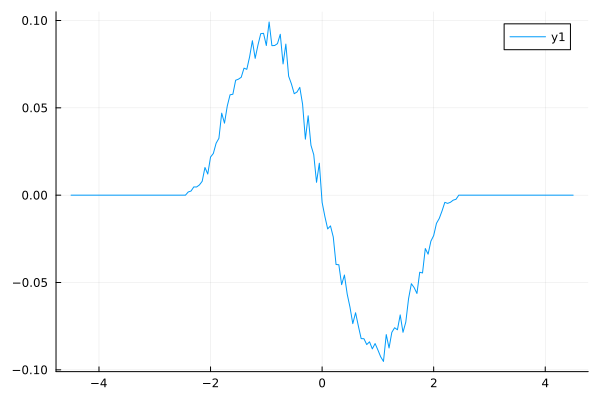

In [8]:
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel

#no. of loci
n=50

geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

#Assign probabilities for all phenotypes
N1=pdf.(Uniform(-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

#Assume that mean trait value for species 1 is 0.0.
#Set the mean trait value for species no. 2
means=collect(-4.5:0.05:4.5)

betas1=betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2
    val=min(means[i],(1.0-means[i]))
    
    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(Uniform(means[i]-1.0,means[i]+1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)

    N1bar=wsample(geno,N1,1000)
    
    N2bar=wsample(geno,N2,1000)

    betas2[i]=mc_gt(N1bar,N2bar,omega,t)
    
end



plot(means,betas1)



In [ ]:
#no. of loci
n=10

geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end
A1

In [ ]:
#Create a multispecies simulation
#Create a starting population

N=zeros(Float64,nsp,nt)

for i in 1:nsp
    
    smp=sample(-4:1:4)

    N[i,:]=pdf.(Uniform(smp-1.0,smp+1.0),geno)
    
end

#N=rand(Uniform(0,1.0), nsp,nt)
Ng0= N ./ (sum.(eachrow(N)))

res=single_sim(A0,A1,R, Ng0, Npop)

In [ ]:
 Np0=Ng0 .*Npop
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)

 Np[findall(sum(Np,dims=2) .< 10),:] .= 0

 newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

In [ ]:
newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

In [ ]:
A0

In [ ]:
 Np0=Ng0 .*Npop
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end
            
        dat[m,:,:]=Ngen
            
        end
    

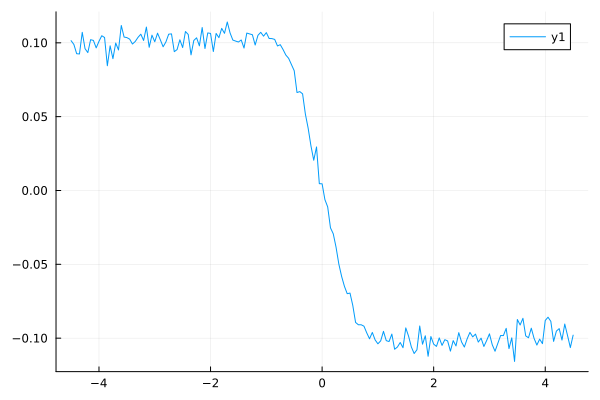

In [6]:
#Case 2: Gaussian traits + truncated gaussian comp. kernel

#no. of loci
n=10

geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

omega=0.5
slope=0.75
t=2.0
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

#Assign probabilities for all phenotypes
N1=pdf.(truncated(Normal(0.0,0.5),-1.0,1.0),geno)

N1=N1 ./ sum(N1)

#Assume that mean trait value for species 1 is 0.0.
#Set the mean trait value for species no. 2
means=collect(-4.5:0.05:4.5)

betas1=betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2
    #val=min(means[i],(1.0-means[i]))
    
    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(truncated(Normal(means[i],0.5),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)

    N1bar=wsample(geno,N1,1000)
    
    N2bar=wsample(geno,N2,1000)

    betas2[i]=mc_gt(N1bar,N2bar,omega,t)
    
end


plot(means,betas1)

In [4]:
geno

21-element Vector{Float64}:
 -5.0
 -4.5
 -4.0
 -3.5
 -3.0
 -2.5
 -2.0
 -1.5
 -1.0
 -0.5
  0.0
  0.5
  1.0
  1.5
  2.0
  2.5
  3.0
  3.5
  4.0
  4.5
  5.0

In [3]:
A1

21×21 Matrix{Float64}:
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
#Case 3: Uniformly distributed traits + triangular comp. kernel


n=50

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)



omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    #A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],omega,t)
    
    A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end


N1=pdf.(Uniform(0.4,0.6),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(truncated(Normal(means[i],0.5),0,1),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas[i]=sum(newfreq .* geno)

end
plot(means .- 0.5,betas .-0.5)

In [ ]:
#Case 4: Normally distributed traits + triangluar comp. kernel


n=5

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    #A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],omega,t)
    
    A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end


N1=pdf.(truncated(Normal(0.5,0.5),0,1),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)
    N2=pdf.(truncated(Normal(means[i],0.5),0,1),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas[i]=sum(newfreq .* geno)

end
plot(means,betas)

In [ ]:
#Plot beta function shapes by varying a)shapes of trait distributions b)competition kernels

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

#First use truncated Gaussian competition kernel

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

    A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
end

A1= A1 ./ 100
A0= A0 ./ 100

n=20

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)


    
#Case 1: Uniformly distributed traits

N1=pdf.(Uniform(),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))
    
    N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)
    
    N2= N2 ./ sum(N2)
    
    
    
    
for i1 in 1:size(newp)[1], i2 in 1:size(newp)[2]
        
        comps=sum(A1[i2,:] .* newp[1:end .!=i1,:]') + sum(A0[i2,:] .* newp[i1,:]) 
        Np[i1,i2]=newp[i1,i2]+(newp[i1,i2]*(1-comps))

end
 




In [ ]:

        
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
        
#Start the simulation
for m in 1:1000
    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0

    if all(sum(Np,dims=2) ==0) 
        break
        else
        
        newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    

In [ ]:
nsp=2
n=10


geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)
    
    N=ones(Float64, nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    
    result=DataFrame()
        
        omega=0.5
        t=0.5
        a1=0.5
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:100
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

                dat1=DataFrame(nloci=n,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)

        end 
        

    

In [ ]:
result

In [ ]:

function compsim(par::Tuple{Int64, Int64})
    
    rep=par[1]
    n=par[2]

    geno= collect(range(-1,stop=1,length=2*n+1))
    nt=length(geno)
    
    N=rand(Uniform(0,1.0), nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    omegas=[0.1,0.5]
    ts=[0.2,0.5,2]
    a1s=[0.1,0.5,1]
    
    result=DataFrame()
        
    for i in omegas, j in ts, k in a1s
        
        omega=i
        t=j
        a1=k
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    
    CSV.write(string("compSK_",rep,"_",n,"_",".csv"),result)

end
